### Notebook Generating Context-from Masking Experiment Results

This notebook generates the main figures (Fig 2, Fig 3 and Fig 4) for Section 4 in The paper "Where does In-context Learning Happen".

https://openreview.net/pdf?id=LLuSjg59an

The results can be obtained by running the baselines and the experiments for different models (GPTN2.7B, Bloom3B, Llama3.1-8B, Llama3.1-8B-Instruct, Starcoder2-7B) and for different task (machine_translation, code_gen). All language directions in FLORES are available for Machine Translation (en-fr, fr-en, en-pt, pt-en), while code_gen currently only supports en-py.

`$>bin/batch_submit_baselines.sh` 

`$>bin/batch_submit_mask_exp.sh` 


In [23]:
#%cd $HOME/projects/where_does_icl_happen
%cd /workspace/where_does_in-context-learning_happen_in_LLMs

/workspace/where_does_in-context-learning_happen_in_LLMs


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install seaborn > /dev/null 2>&1
!pip install omegaconf > /dev/null 2>&1

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

import json
import seaborn
sns.set_style('whitegrid')

from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import argparse
import os

rd = lambda x: np.around(x, 2)

### Load Default args for `exp = mask_context_from`

In [4]:
exp = "mask_context_from"

baseline_cfp = OmegaConf.load(f'configs/file_paths/default.yaml')
cfp = OmegaConf.load(f"configs/file_paths/{exp}.yaml")
model_cf = OmegaConf.load(f'configs/model/masks/{exp}_TTT.yaml')
data_cf = OmegaConf.load('configs/data/default.yaml')
format_cf = OmegaConf.load('configs/format/instr_none_QA.yaml')
generator_cf = OmegaConf.load('configs/generator/default.yaml')
training_cf = OmegaConf.load('configs/training/default.yaml')
prompt_cf = OmegaConf.load('configs/prompt_select/random.yaml')

args = OmegaConf.merge(model_cf, data_cf, format_cf, generator_cf, training_cf, prompt_cf, baseline_cfp)
args.seed = 0
args.sample_prompts.nprompts = nprompts = 5

#### Load specific args for exp = mask_context_from

In [17]:
# en-fr settings

models = ['Llama-3.1-8B', 'Llama-3.1-8B-Instruct'] # ['starcoder2-7B', 'Llama-3.1-8B', 'Llama-3.1-8B-Instruct', 'gptn2.7B', 'bloom3b']

domain = "machine_translation" #"code_gen" # "translation"

if domain == "code_gen":
    instrs = ['instr_code_gen', 'instr_none_QA']
    args.data.trainset = "MBPP"
    args.data.testset = "HEVAL"
    args.data.direction = "en-py"
    conditions = [('instr_none_QA', nprompts, False, True, False), 
                  ("instr_code_gen", nprompts, True, True, False),
                  ("instr_code_gen", nprompts, False, True, False),
                  ("instr_code_gen", nprompts, False, False, True),
                  ("instr_code_gen", nprompts, True, True, True)]
    y='pass@1'
else:
    args.data.trainset = "FLORES"
    args.data.testset = "FLORES"
    args.data.direction = "en-fr"
    conditions = [("instr_none_QA", nprompts, False, True, False), 
                  ("instr_machine_translation", nprompts, True, True, False),
                ("instr_machine_translation", nprompts, False, True, False),
                ("instr_machine_translation", nprompts, False, False, True),
                ("instr_machine_translation", nprompts, True, True, True),
]
    y='bleu'

# code_gen settings
#models = ['starcoder2-3B', 'starcoder2-7B']
#models = ['llama7b', 'llama7b-chat']


### Load data into the DataFrame for Plotting|

In [18]:
model_layers = {"gptn125M":12,
                "gptn2.7B":32, 
                "bloom3b":30, 
                "llama7b": 32, 
                "llama7b-chat":32,
                "Llama-3.1-8B-Instruct":32,
                "Llama-3.1-8B": 32,
                "starcoder2-3B":32, 
                "starcoder2-7B":32}

name_dict = {'instr_none_QA_Instructions-False-maskPrompts-True': r"$\overline{Ex}^{Mask}Query$",
            'instr_machine_translation_Instructions-True-maskPrompts-True':r"$\overline{Instr, Ex}^{Mask}Query$",
            'maskQuery':r"$\overline{Instr, Ex, Query}^{Mask}$",
             'maskQueryOnly':r"$Instr, Ex, \overline{Query}^{Mask}$",
            'instr_machine_translation_Instructions-False-maskPrompts-True':r"$Instr, \overline{Ex}^{Mask}Query$",
            'instr_code_gen_Instructions-True-maskPrompts-True':r"$\overline{Instr, Ex}^{Mask}Query$",
            'instr_code_gen_Instructions-False-maskPrompts-True':r"$Instr, \overline{Ex}^{Mask}Query$"
            }

def get_df(cfp, args):
    df = []
    nlayers = model_layers[args.model.model_size]

    if args.model.causal_mask.instructions and args.model.causal_mask.query:
        name = "maskQuery"
        print("name:", name)
    elif not args.model.causal_mask.instructions and args.model.causal_mask.query:
        name = "maskQueryOnly"

    else:
        name = f"{args.format.name}_Instructions-{args.model.causal_mask.instructions}-maskPrompts-{args.model.causal_mask.prompts}" 

    for j in range(nlayers):
        for s in range(2):
            
            args.model.mask_layer = j
            args.seed = s
            fn = cfp['res_fn'].format(**args) # + ".temp"
            if not os.path.exists(fn):
                #print(fn)
                continue
                
            with open(fn, 'r') as f:
                data = json.load(f)

                if type(data) == list:
                    data = data[0]

            data_ = {"layer": j+1, "seed": s, "model": args.model.model_size, 'name': name_dict[name]}
            data.update(data_)
            df.append(data)
                
    df = pd.DataFrame(df)
    return df 


In [19]:
all_df = []
i = 0
print(conditions)
for model in models:
    for (instr, nprompt, mask_instr, mask_ex, mask_query) in conditions:
        args.format.name = instr
        args.model.model_size = model
        args.sample_prompts.nprompts = nprompt
        args.model.causal_mask.instructions = mask_instr
        args.model.causal_mask.query = mask_query
        args.model.causal_mask.prompts = mask_ex
        df = get_df(cfp, args)
        all_df.append(df)
            
all_df = pd.DataFrame(pd.concat(all_df))
all_df = all_df.drop_duplicates()
print(len(all_df))

[('instr_none_QA', 5, False, True, False), ('instr_machine_translation', 5, True, True, False), ('instr_machine_translation', 5, False, True, False), ('instr_machine_translation', 5, False, False, True), ('instr_machine_translation', 5, True, True, True)]
name: maskQuery
name: maskQuery
563


### Preparing to plot

In [20]:

def get_baseline(args, models):
    base_scores = {}

    for model in models:
        for args.seed in range(1):
            args.model.model_size = model
            args.format.name = f"instr_{domain}"
            fn = args['res_fn_baseline'].format(**args) 
            if not os.path.exists(fn):
                continue
                
            with open(fn, 'rb') as f:
                data = json.load(f)
            if type(data) == list:
                data = data[0]
                
            base_scores[model] = {}
            base_scores[model][args.data.direction] = base_scores[model].get(args.data.direction, []) + [data[y]]
    return base_scores

base_scores = get_baseline(args, models)
print(base_scores)

{'Llama-3.1-8B': {'en-fr': [40.948]}, 'Llama-3.1-8B-Instruct': {'en-fr': [40.758]}}


0 Llama-3.1-8B
1 Llama-3.1-8B-Instruct


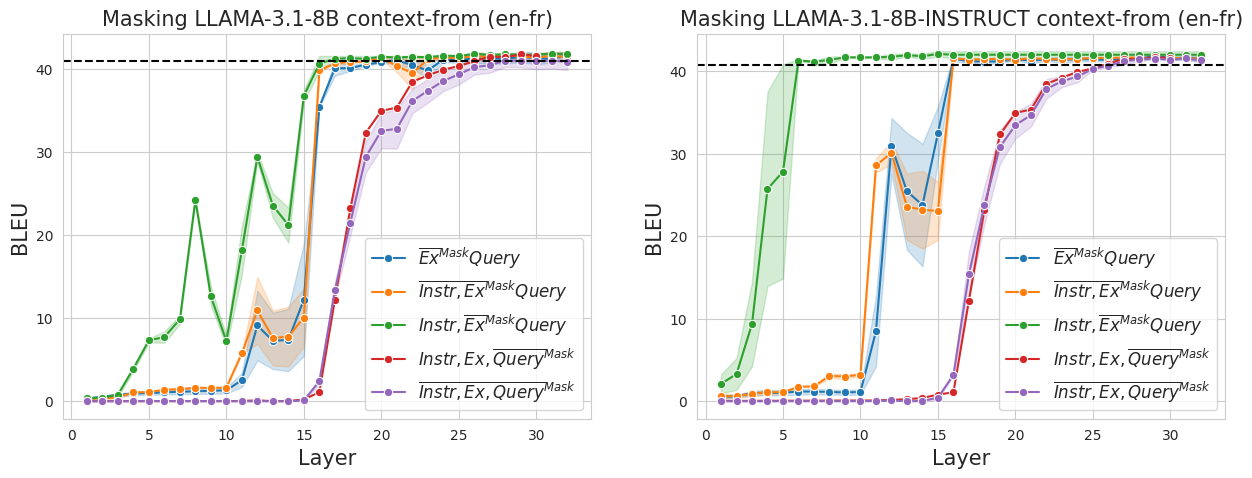

In [21]:
figs, axs = plt.subplots(1,len(models), figsize=(15, 5))
for i, model in enumerate(models):
    print(i, model)
    sns.lineplot(ax=axs[i], data=all_df[all_df['model']==model], x="layer", y=y, hue="name", marker="o")
    axs[i].axhline(y=np.mean(base_scores[model][args.data.direction]), color='black', linestyle="--")

    axs[i].set_ylabel(y.upper(), fontsize=15)
    axs[i].set_xlabel('Layer', fontsize=15)
    axs[i].set_title(f"Masking {model.upper()} context-from ({args.data.direction})", fontsize=15)
    axs[i].legend(fontsize=12)

plt.show()

Layer-from context-masking experiments for LLAMA3.1-8B, LLAMA3.1-8B-INSTRUCT
en→fr (main figure). The graphs show translation performance when masking contexts from
the jth layer onwards. Different lines indicate different masking treatments, as described in Figure 1.
The dashed black line is the performance when no masking of the input occurs.